<a href="https://colab.research.google.com/github/bishan5/A-Predictive-Traffic-Flow-Modelling-for-ITS/blob/main/MultivariateLSTMModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Import Necessary Libraries**

In [ ]:
# Basic data manipulation and numerical operations
import numpy as np
import pandas as pd

# Machine learning tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Deep learning imports - TensorFlow and Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Google Colab specific
from google.colab import files
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
FILE_PATH = '/content/drive/MyDrive/Clean_Metro_Interstate_Traffic_Volume.csv'
data = pd.read_csv(FILE_PATH)

In [ ]:
data

,Timestamp,Traffic_volume,Holiday,Temp,Rain_1h,Snow_1h,Clouds_all,Weather_main,weather_description
0,01/07/2015 00:00,737,NaN,289.20,0.0,0.0,1.0,Clear,sky is clear
1,01/07/2015 01:00,444,NaN,289.40,0.0,0.0,1.0,Clear,sky is clear
2,01/07/2015 02:00,347,NaN,289.19,0.0,0.0,1.0,Clear,sky is clear
3,01/07/2015 03:00,356,NaN,288.74,0.3,0.0,1.0,Rain,light rain
4,01/07/2015 04:00,936,NaN,288.07,0.0,0.0,1.0,Clear,sky is clear
...,...,...,...,...,...,...,...,...,...
28507,30/09/2018 19:00,3543,NaN,283.45,0.0,0.0,75.0,Clouds,broken clouds
28508,30/09/2018 20:00,2781,NaN,282.76,0.0,0.0,90.0,Clouds,overcast clouds
28509,30/09/2018 21:00,2159,NaN,282.73,0.0,0.0,90.0,Thunderstorm,proximity thunderstorm
28510,30/09/2018 22:00,1450,NaN,282.09,0.0,0.0,90.0,Clouds,overcast clouds


<ipython-input-5-1800c1f1d88e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['Day_Type'] = recent_data['Timestamp'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
<ipython-input-5-1800c1f1d88e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['Day_Label'] = recent_data['Timestamp'].dt.strftime('%a %b %d %H:%M')  # Format: 'Day Month Date Hour:Minute'


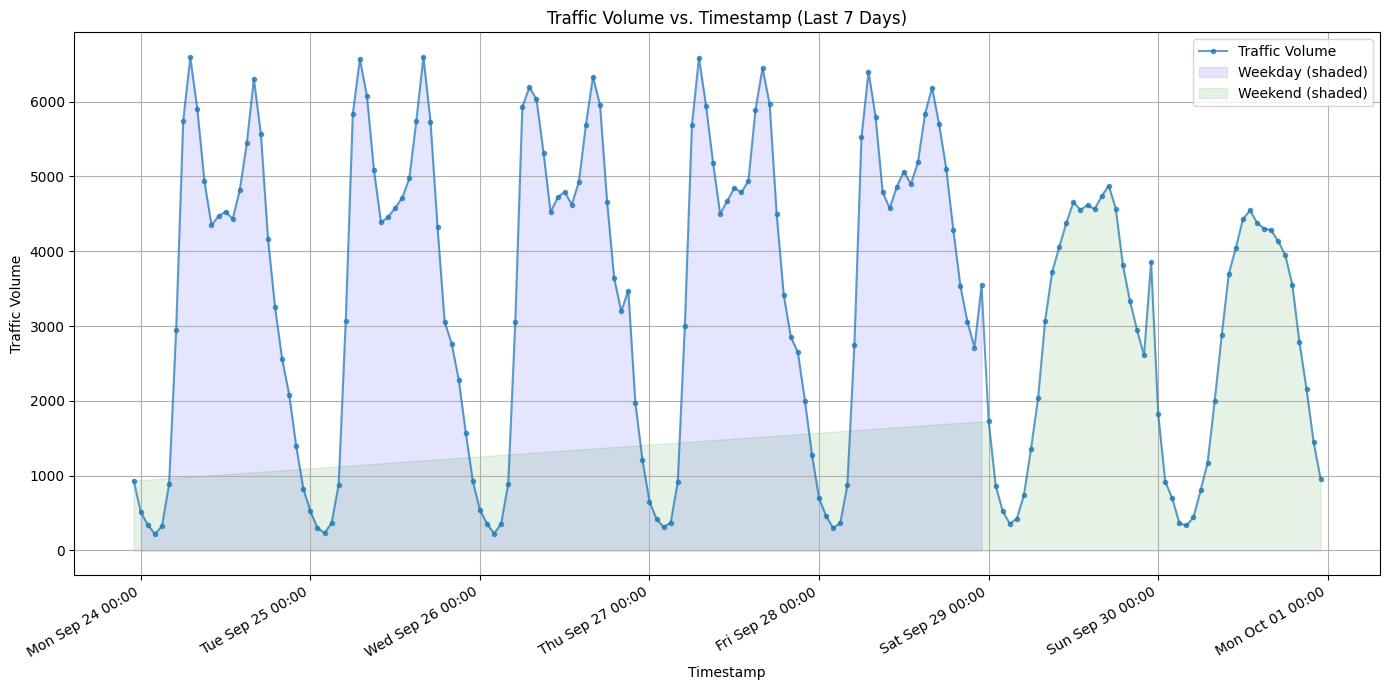

In [ ]:
# Convert the 'Timestamp' column to datetime objects
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d/%m/%Y %H:%M')

# Filter data for the last 7 days
last_7_days = data['Timestamp'].max() - pd.Timedelta(days=7)
recent_data = data[data['Timestamp'] >= last_7_days]

# Identify weekdays and weekends
recent_data['Day_Type'] = recent_data['Timestamp'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Add the day of the week to the x-axis labels
recent_data['Day_Label'] = recent_data['Timestamp'].dt.strftime('%a %b %d %H:%M')  # Format: 'Day Month Date Hour:Minute'

# Create the plot
plt.figure(figsize=(14, 7))

# Plot traffic volume
plt.plot(recent_data['Timestamp'], recent_data['Traffic_volume'], label='Traffic Volume', alpha=0.7, linestyle='-', marker='o', markersize=3)

# Color-code weekdays and weekends
for day_type in ['Weekday', 'Weekend']:
    filtered_data = recent_data[recent_data['Day_Type'] == day_type]
    plt.fill_between(
        filtered_data['Timestamp'],
        0,
        filtered_data['Traffic_volume'],
        alpha=0.1,
        label=f'{day_type} (shaded)',
        color='blue' if day_type == 'Weekday' else 'green'
    )

# Format x-axis to show day labels
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a %b %d %H:%M'))  # Format includes day

# Enhance the plot
plt.xlabel('Timestamp')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume vs. Timestamp (Last 7 Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


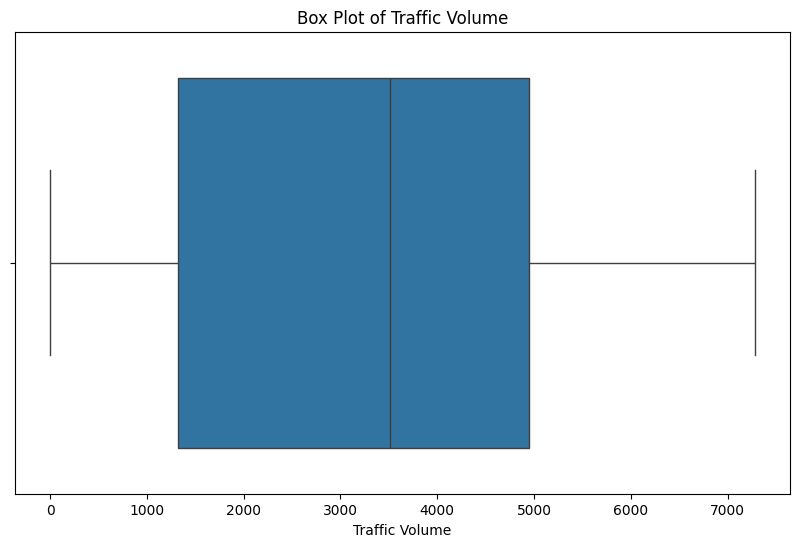

In [ ]:
# create box plot

plt.figure(figsize=(10, 6))
sns.boxplot(x='Traffic_volume', data=data)
plt.title('Box Plot of Traffic Volume')
plt.xlabel('Traffic Volume')
plt.show()

In [ ]:
# Calculate the first quartile (Q1) and third quartile (Q3) of the traffic volume
Q1 = data['Traffic_volume'].quantile(0.25)
Q3 = data['Traffic_volume'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
data = data[~((data['Traffic_volume'] < lower_bound) | (data['Traffic_volume'] > upper_bound))]



**Feature extraction**

In [ ]:
# Convert 'Holiday' column values: NaN to 0, others to 1
data['Holiday'] = data['Holiday'].apply(lambda x: 0 if pd.isna(x) else 1)


In [ ]:
# Convert 'Timestamp' to datetime and extract features
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d/%m/%Y %H:%M')
data['Hour'] = data['Timestamp'].dt.hour
data['Day'] = data['Timestamp'].dt.day
data['Weekday'] = data['Timestamp'].dt.weekday
data['Is_night'] = data['Hour'].isin([22,23,0,1,2,3,4,5])
data['Month'] = data['Timestamp'].dt.month
data['Is_weekend'] = data['Weekday'].isin([5, 6])
data['Year'] = data['Timestamp'].dt.year

In [ ]:
data.head()

,Timestamp,Traffic_volume,Holiday,Temp,Rain_1h,Snow_1h,Clouds_all,Weather_main,weather_description,Hour,Day,Weekday,Is_night,Month,Is_weekend,Year
0,2015-07-01 00:00:00,737,0,289.20,0.0,0.0,1.0,Clear,sky is clear,0,1,2,True,7,False,2015
1,2015-07-01 01:00:00,444,0,289.40,0.0,0.0,1.0,Clear,sky is clear,1,1,2,True,7,False,2015
2,2015-07-01 02:00:00,347,0,289.19,0.0,0.0,1.0,Clear,sky is clear,2,1,2,True,7,False,2015
3,2015-07-01 03:00:00,356,0,288.74,0.3,0.0,1.0,Rain,light rain,3,1,2,True,7,False,2015
4,2015-07-01 04:00:00,936,0,288.07,0.0,0.0,1.0,Clear,sky is clear,4,1,2,True,7,False,2015


In [ ]:
# 1. Encode 'Year' using Ordinal Encoding (2015-2018 → 0-3)
data['Year'] = data['Year'] - 2015

# 2. Convert Boolean features to integers (Binary Encoding)
data['Is_weekend'] = data['Is_weekend'].astype(int)
data['Is_night'] = data['Is_night'].astype(int)
data['Holiday'] = data['Holiday'].astype(int)

# 3. Apply Label Encoding for 'Weather_main'
label_encoder = LabelEncoder()
data['Weather_main'] = label_encoder.fit_transform(data['Weather_main'])



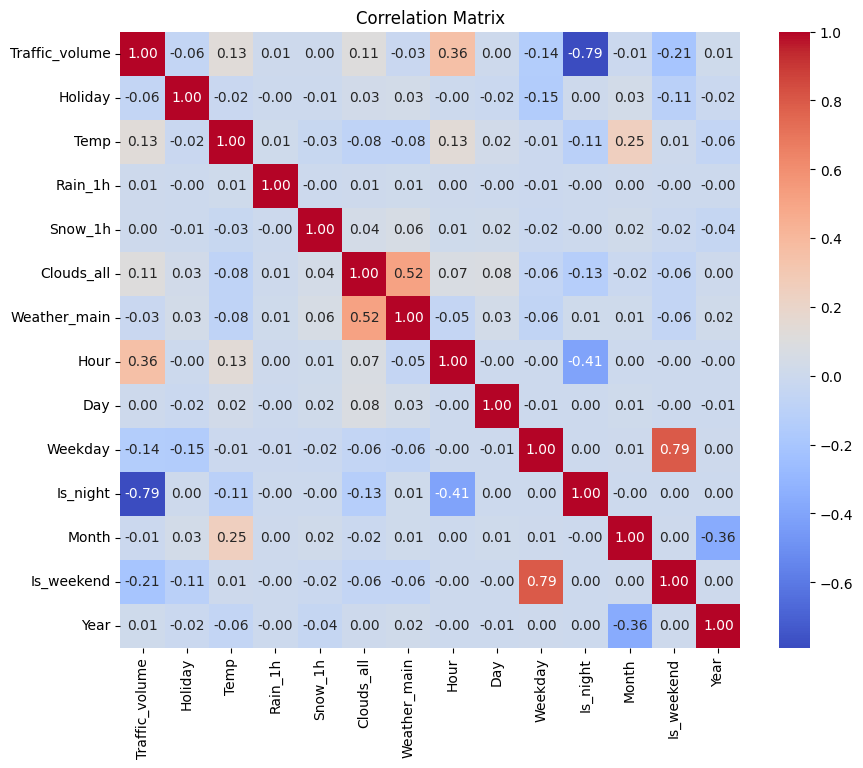

In [ ]:
plt.figure(figsize=(10, 8))
# Select only numeric columns for correlation calculation
numeric_data = data.select_dtypes(include=['number'])
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# List of features to use for prediction
features = ['Traffic_volume', 'Hour', 'Weekday', 'Temp', 'Weather_main', 'Clouds_all', 'Is_weekend', 'Is_night']

# Target variable
target = 'Traffic_volume'

In [ ]:
# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Select the features from the DataFrame
X = data[features]

# Apply scaling to the feature data
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(data[target].values.reshape(-1, 1))

**Step 2: Prepare the Data**

In [ ]:
# Function to create sequences with lookback and predict next 3 hours
look_back = 24  # Use past 24 hours for prediction
n_hours_to_predict = 3  # Predict the next 3 hours

def create_dataset(features, target, look_back=1, n_hours_to_predict=3):
    X, y = [], []
    for i in range(len(features) - look_back - n_hours_to_predict + 1):
        X.append(features[i:i + look_back])
        y.append(target[i + look_back:i + look_back + n_hours_to_predict])
    return np.array(X), np.array(y)

X, y = create_dataset(X_scaled, y_scaled, look_back, n_hours_to_predict)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")



Training data shape: (22788, 24, 8), (22788, 3, 1)
Testing data shape: (5698, 24, 8), (5698, 3, 1)


Keras Tuner is used to explore and identify the optimal combinations of hyperparameters for improved model performance. I have run the code and updated it in the next block, so you can skip ahead to the next code block for model building.

**Step 3: Build the LSTM Model**

In [ ]:
!pip install tensorflow
!pip install keras-tuner # Install Keras Tuner
# Import Keras Tuner
from kerastuner import HyperModel, RandomSearch
import tensorflow as tf # Import TensorFlow
# Import necessary callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define EarlyStopping and ReduceLROnPlateau before tuner.search
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Define the HyperModel class
class TrafficVolumeHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()

        # Tune the number of units in the first LSTM layer
        model.add(LSTM(
            units=hp.Int('units_1', min_value=32, max_value=256, step=32),
            return_sequences=True,
            input_shape=self.input_shape
        ))
        model.add(Dropout(
            rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
        ))

        # Tune the number of units in the second LSTM layer
        model.add(LSTM(
            units=hp.Int('units_2', min_value=32, max_value=256, step=32),
            return_sequences=False
        ))
        model.add(Dropout(
            rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
        ))

        # Tune the number of units in the Dense layer
        model.add(Dense(
            units=hp.Int('dense_units', min_value=16, max_value=128, step=16),
            activation='relu'
        ))

        # Output layer for predicting the next 3 hours
        model.add(Dense(24))

        # Tune the learning rate
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # Compile the model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), # Use tf here
            loss='mean_squared_error',
            metrics=['mae']
        )

        return model

# Initialize the HyperModel
hypermodel = TrafficVolumeHyperModel(input_shape=(look_back, X_train.shape[2]))

# Initialize the tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='keras_tuner',
    project_name='traffic_volume_prediction'
)

# Perform hyperparameter search
tuner.search(
    X_train, y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

# Get the best model
model = tuner.get_best_models(num_models=1)[0]

# Summary of the best model
model.summary()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/129.1 kB ? eta -:--:--
ERROR: Operation cancelled by user


ModuleNotFoundError: No module named 'kerastuner'

In [ ]:
# Build the LSTM Model
# Parameter choosen based on keras tuner iteration in above code
def build_lstm_model(input_shape):
    model = Sequential()

    # First LSTM layer with dropout
    model.add(LSTM(224, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.4))

    # Second LSTM layer with dropout
    model.add(LSTM(160, return_sequences=False))
    model.add(Dropout(0.4))

    # Dense layer
    model.add(Dense(48, activation='relu'))

    # Output layer for predicting the next 3 hours
    model.add(Dense(3))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

# Build and compile the model
model = build_lstm_model(input_shape=(look_back, X_train.shape[2]))

# Summary of the model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 224)             │         208,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 224)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 160)                 │         246,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 48)                  │           7,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 463,043 (1.77 MB)

 Trainable params: 463,043 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0323 - mae: 0.1269 - val_loss: 0.0069 - val_mae: 0.0579 - learning_rate: 0.0010
Epoch 2/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0081 - mae: 0.0646 - val_loss: 0.0055 - val_mae: 0.0518 - learning_rate: 0.0010
Epoch 3/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0064 - mae: 0.0564 - val_loss: 0.0055 - val_mae: 0.0493 - learning_rate: 0.0010
Epoch 4/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0055 - mae: 0.0524 - val_loss: 0.0038 - val_mae: 0.0382 - learning_rate: 0.0010
Epoch 5/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0048 - mae: 0.0491 - val_loss: 0.0040 - val_mae: 0.0412 - learning_rate: 0.0010
Epoch 6/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0043 - mae: 0.0469 - val_loss: 0.0038 - val_mae: 0.0419 - learning_rate: 0.0010
Epoch 7/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0042 - mae: 0.0457 - val_loss: 0.0031 - val_mae: 0.0353 - learning_rate: 0.

In [ ]:
# Predictions for train and test sets
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Reshape predictions and targets
train_predict_reshaped = train_predict.reshape(-1, 3)
test_predict_reshaped = test_predict.reshape(-1, 3)
y_train_reshaped = y_train.reshape(-1, 3)
y_test_reshaped = y_test.reshape(-1, 3)

In [ ]:
# Reverse scaling to get actual values
y_train_rescaled = scaler_y.inverse_transform(y_train_reshaped)
train_predict_rescaled = scaler_y.inverse_transform(train_predict_reshaped)
y_test_rescaled = scaler_y.inverse_transform(y_test_reshaped)
test_predict_rescaled = scaler_y.inverse_transform(test_predict_reshaped)

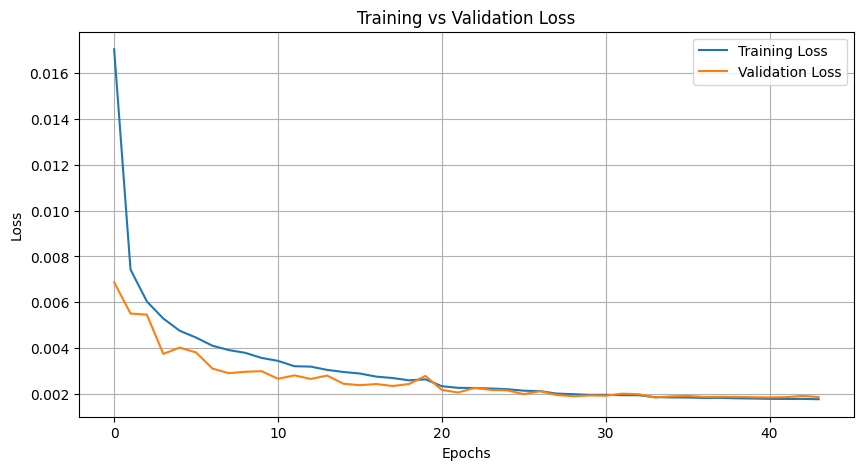

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()

In [ ]:
# Define horizons for evaluation
horizons = range(1, 4)  # From 1-hour to 3-hour forecasts

# Initialize metrics dictionary
metrics = {
    "Training": {},
    "Testing": {}
}

# Loop through each forecast horizon
for i in horizons:
    # Training metrics for i-hour forecast
    train_mse = mean_squared_error(y_train_rescaled[:, i - 1], train_predict_rescaled[:, i - 1])
    train_mae = mean_absolute_error(y_train_rescaled[:, i - 1], train_predict_rescaled[:, i - 1])
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train_rescaled[:, i - 1], train_predict_rescaled[:, i - 1])

    # Testing metrics for i-hour forecast
    test_mse = mean_squared_error(y_test_rescaled[:, i - 1], test_predict_rescaled[:, i - 1])
    test_mae = mean_absolute_error(y_test_rescaled[:, i - 1], test_predict_rescaled[:, i - 1])
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test_rescaled[:, i - 1], test_predict_rescaled[:, i - 1])

    # Store metrics in the dictionary
    metrics["Training"][f"{i}-Hour"] = {"MAE": train_mae, "RMSE": train_rmse, "R2": train_r2}
    metrics["Testing"][f"{i}-Hour"] = {"MAE": test_mae, "RMSE": test_rmse, "R2": test_r2}

# Print the metrics in a formatted way
for dataset, forecast_metrics in metrics.items():
    print(f"\n{dataset} Evaluation Metrics:")
    for forecast, values in forecast_metrics.items():
        print(f"  {forecast} Forecast:")
        for metric, score in values.items():
            print(f"    {metric}: {score:.4f}")



Training Evaluation Metrics:
  1-Hour Forecast:
    MAE: 170.3229
    RMSE: 251.2045
    R2: 0.9835
  2-Hour Forecast:
    MAE: 197.2613
    RMSE: 299.0152
    R2: 0.9766
  3-Hour Forecast:
    MAE: 210.6433
    RMSE: 323.8268
    R2: 0.9726

Testing Evaluation Metrics:
  1-Hour Forecast:
    MAE: 155.9361
    RMSE: 229.9061
    R2: 0.9866
  2-Hour Forecast:
    MAE: 176.0866
    RMSE: 270.5991
    R2: 0.9814
  3-Hour Forecast:
    MAE: 192.8198
    RMSE: 303.3308
    R2: 0.9767


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


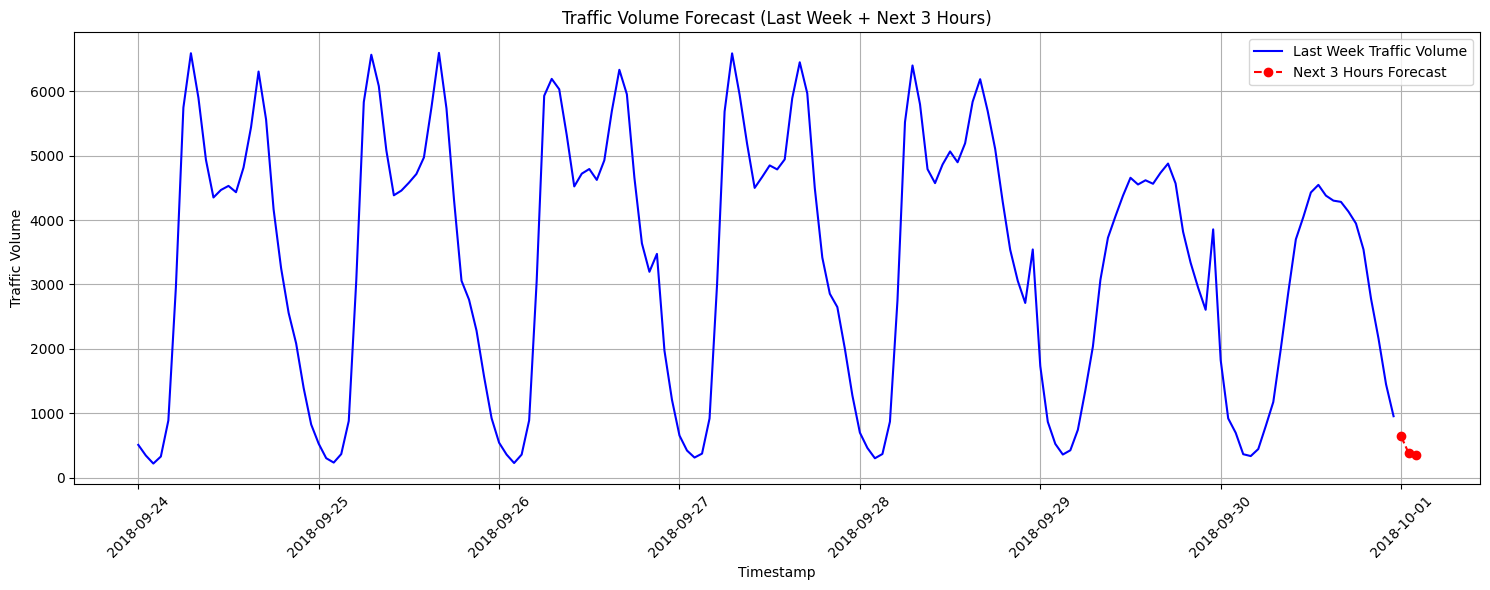

,Timestamp,Predicted_Traffic_Volume
0,2018-10-01 00:00:00,642.040710
1,2018-10-01 01:00:00,383.739075
2,2018-10-01 02:00:00,348.137848


In [ ]:
# Get the last 'look_back' hours of data from the original dataset
last_data_points = X_scaled[-look_back:].reshape(1, look_back, X_scaled.shape[1])

# Predict the next 3 hours
next_3_hours_prediction_scaled = model.predict(last_data_points)

# Reshape the prediction
next_3_hours_prediction_scaled = next_3_hours_prediction_scaled.reshape(1, -1)

# Inverse transform the prediction to get actual values
next_3_hours_prediction = scaler_y.inverse_transform(next_3_hours_prediction_scaled)

# Reshape the prediction
next_3_hours_prediction_scaled = next_3_hours_prediction_scaled.reshape(1, -1)

# Inverse transform the prediction to get actual values
next_3_hours_prediction = scaler_y.inverse_transform(next_3_hours_prediction_scaled)

# Get the timestamps for the next 3 hours
last_timestamp = data['Timestamp'].iloc[-1]
next_3_hours_timestamps = [last_timestamp + pd.Timedelta(hours=i) for i in range(1, 4)]

# Create a DataFrame for the prediction
prediction_df = pd.DataFrame({
    'Timestamp': next_3_hours_timestamps,
    'Predicted_Traffic_Volume': next_3_hours_prediction[0]
})

# Concatenate with the last week data
last_week_data = data[['Timestamp', 'Traffic_volume']].tail(168) # Get the last 7 days (168 hours)
combined_df = pd.concat([last_week_data, prediction_df], ignore_index=True)

# Plot the combined data
plt.figure(figsize=(15, 6))

plt.plot(combined_df['Timestamp'], combined_df['Traffic_volume'], label='Last Week Traffic Volume', color='blue')
plt.plot(prediction_df['Timestamp'], prediction_df['Predicted_Traffic_Volume'], label='Next 3 Hours Forecast', color='red', marker='o', linestyle='dashed')

plt.xlabel('Timestamp')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume Forecast (Last Week + Next 3 Hours)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a DataFrame for the prediction
prediction_df = pd.DataFrame({
    'Timestamp': next_3_hours_timestamps,
    'Predicted_Traffic_Volume': next_3_hours_prediction[0]
})

# Display the forecast
prediction_df

Latest available date: 2018-09-30
Enter a date (YYYY-MM-DD): 2018-09-27


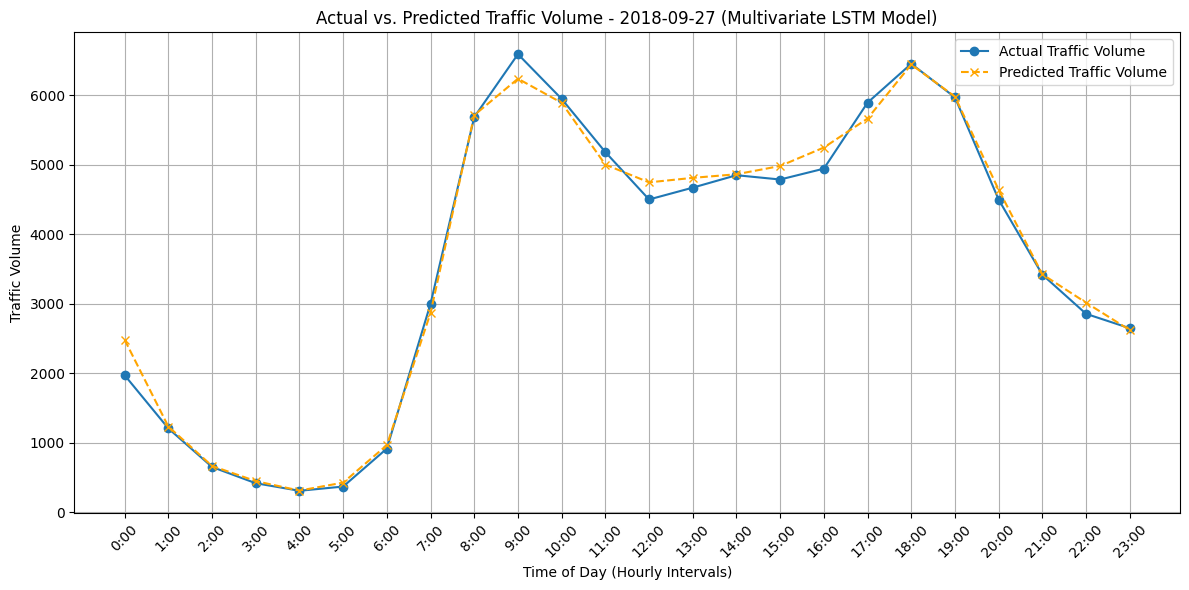

In [ ]:
# Allow user to enter a date (YYYY-MM-DD)
latest_date = data['Timestamp'].max().date()
print(f"Latest available date: {latest_date}")
selected_date = input("Enter a date (YYYY-MM-DD): ")

try:
    selected_date = pd.to_datetime(selected_date).date()

    # Filter data for the selected date
    filtered_indices = [
        i for i, timestamp in enumerate(data['Timestamp'][-len(y_test_rescaled):])
        if timestamp.date() == selected_date
    ]

    if not filtered_indices:
        print(f"No data available for the selected date: {selected_date}.")
    else:
        # Select the first occurrence of the date
        day_index = filtered_indices[0]

        # Define 24-hour window
        start_index = day_index
        end_index = min(day_index + 24, len(y_test_rescaled))

        # Extract actual and predicted traffic data
        actual_traffic = y_test_rescaled[start_index:end_index, 0]
        predicted_traffic = test_predict_rescaled[start_index:end_index, 0]

        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(actual_traffic)), actual_traffic, label='Actual Traffic Volume', marker='o')
        plt.plot(range(len(predicted_traffic)), predicted_traffic, label='Predicted Traffic Volume', marker='x', linestyle='dashed', color='orange')
        plt.xlabel('Time of Day (Hourly Intervals)')
        plt.ylabel('Traffic Volume')
        plt.title(f'Actual vs. Predicted Traffic Volume - {selected_date} (Multivariate LSTM Model)')
        plt.legend()
        plt.grid(True)
        plt.xticks(range(len(actual_traffic)), labels=[f"{h}:00" for h in range(len(actual_traffic))], rotation=45)
        plt.tight_layout()
        plt.show()

except ValueError:
    print("Invalid date format! Please enter a date in YYYY-MM-DD format.")
